# 멋진 단어 사전 만들기 프로젝트

## SentencePice 사용하기 루브릭
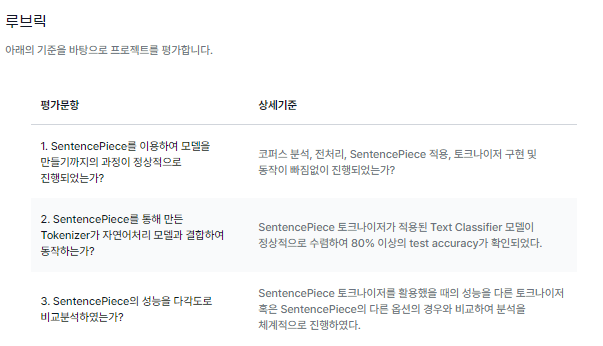

- 라이브러리 버전 확인

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

import os

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

%matplotlib inline

2.6.0
1.21.4
3.4.3
0.5.2


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1. SentencePiece 설치하기

In [3]:
# $ pip install sentencepiece 터미널에 입력

## Step 2. SentencePice 모델 학습

- MeCab 클래스 활용 실습

In [4]:
from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리딥다이브1일차뭔가블로그도재개하고파이팅하는중'))

['자연어', '처리', '딥', '다이브', '1', '일', '차', '뭔가', '블로그', '도', '재개', '하', '고', '파이팅', '하', '는', '중']


### 데이터 다운로드 및 분석

- 네이버 영화리뷰 감정 분석 태스크 데이터 가져오기

In [5]:
# 데이터 깃클론
!git clone https://github.com/e9t/nsmc.git ~/review

Cloning into '/aiffel/review'...
remote: Enumerating objects: 14763, done.
remote: Counting objects: 100% (14762/14762), done.
remote: Compressing objects: 100% (13012/13012), done.
remote: Total 14763 (delta 1748), reused 14762 (delta 1748), pack-reused 1 (from 1)
Receiving objects: 100% (14763/14763), 56.19 MiB | 20.64 MiB/s, done.
Resolving deltas: 100% (1748/1748), done.
Updating files: 100% (14737/14737), done.


- 데이터 사이즈, 예시 살펴보기

In [6]:
path_to_file = os.getenv('HOME')+'/review/ratings_train.txt'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()
    
print("Data size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]:print(">>", sen)

Data size: 150001
Example:
>> id	document	label
>> 3989148	약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요.	1
>> 4805788	이 영화가 왜 이렇게 저평가 받는지 모르겠다	1
>> 8317483	백봉기 언제나오나요?	1
>> 9801316	아햏햏 아햏햏 아햏햏.	1


- 문장 최단길이, 최장길이, 평균길이 출력
* 최단 8, 최장 168 이다.

문장 최단 길이:  8
문장 최장 길이:  168
문장 평균 길이:  45


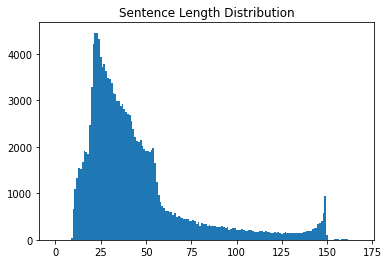

In [7]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    
print("문장 최단 길이: ", min_len)
print("문장 최장 길이: ", max_len)
print("문장 평균 길이: ", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

- 최빈값도 확인

최빈 문장 길이:  23
최빈 문장 길이의 빈도:  4454


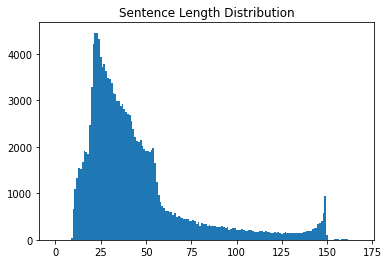

In [8]:
# 최빈 문장 길이 구하기
most_frequent_length = np.argmax(sentence_length) + 1  # 길이 인덱스가 0부터 시작하므로 +1
most_frequent_count = sentence_length[most_frequent_length - 1]

print("최빈 문장 길이: ", most_frequent_length)
print("최빈 문장 길이의 빈도: ", most_frequent_count)

# 기존의 분포 그래프
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


- 데이터 전처리를 위한 데이터 확인 과정

In [9]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

최단 길이인 8에 대해 확인

In [10]:
check_sentence_with_length(raw, 8)

6859	짱	1


최장 길이인 168에 대해 확인

In [11]:
check_sentence_with_length(raw, 168)

7721886	"""스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 """"카탈로그 책자""""를 """"동영상으로 보여주는 방송"""" 같아서 씁쓸하네요.!"""	0
8073750	"""""""니 짓은 생각않고, 웬 복수!""""의 교훈이라! 그럼 """"서바이벌 액션""""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"""	0
6432633	"""2007.02.25_ 벌교의 한 국밥집_ 점심: """"갸는 첫째고, 저 놈은 우리 둘째~"""" 재문: """"아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"""" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"""	1


평균인 45에 대해 확인

In [12]:
# check_sentence_with_length(raw, 45)

최빈값 23에 대해 확인

In [13]:
# check_sentence_with_length(raw, 23)

- 중복값 제외
중복값이 없으므로 삭제되지 않음

Data Size: 150001
문장의 최단 길이: 8
문장의 최장 길이: 168
문장의 평균 길이: 45


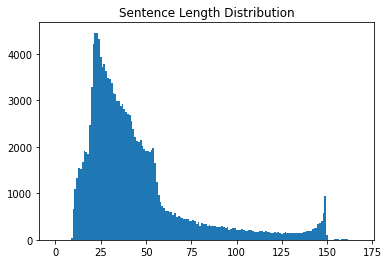

In [14]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

- 길이가 너무 짧거나 긴 것들 제거

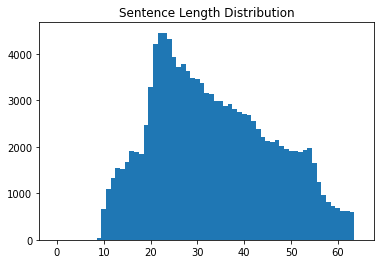

In [15]:
max_len = 65
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 공백 기반 토큰화

- 토크나이저 선언
' ' 공백을 기준으로 토큰을 끊음

In [16]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

정제된 데이터 filtered_corpus를 공백 기반으로 토큰화 하여 저장

In [17]:
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

공백 기반 토큰화 진행 후 단어 사전의 길이 확인

In [18]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 354533


생성된 단어 사전 확인

In [19]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 1
1 : 0
2 : 영화
3 : 너무
4 : 정말
5 : 진짜
6 : 이
7 : 영화.
8 : 왜
9 : 이런
10 : 그냥
11 : 더


### 형태소 기반 토큰화

- MeCab 클래스를 활용하여 토크나이저 생성

In [20]:
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

단어사전 길이 확인

In [21]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 167798


### Tensor를 문장으로 Decoding하는 방법

In [22]:
# Case 1 : tokenizer.sequences_to_texts()

texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

10021206 촌 스럽 다 . 뭔가 노력 한 흔적 은 보이 지만 인물 배경 스토리 까지 요즘 영화 같 지 않 다는 . . 0


In [23]:
# Case 2 : tokenizer.index_word

sentence = ""

for w in mecab_tensor[100]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + " "

print(sentence)

10021206 촌 스럽 다 . 뭔가 노력 한 흔적 은 보이 지만 인물 배경 스토리 까지 요즘 영화 같 지 않 다는 . . 0 


## SentencePice 적용

In [222]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/review/ratings.txt'

vocab_size = 8000

with open(temp_file, 'w', encoding='utf-8') as f: # 단어사전 인코딩 에러 해결 encoding = 'utf-8' 지정
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

### 모델과 단어사전 모두 인코딩 에러
- 단어사전 인코딩 에러 해결 encoding = 'utf-8' 지정 - 윗 코드블록 주석 표시
- 모델도 에러가 발생했으나, 모델 load 하고 사용하는데 문제가 없어보여 우선 패스
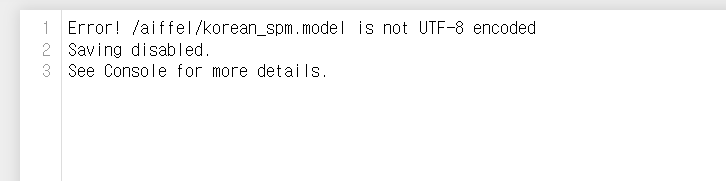

- SentencePiece를 쓰는데 문제가 없어보임
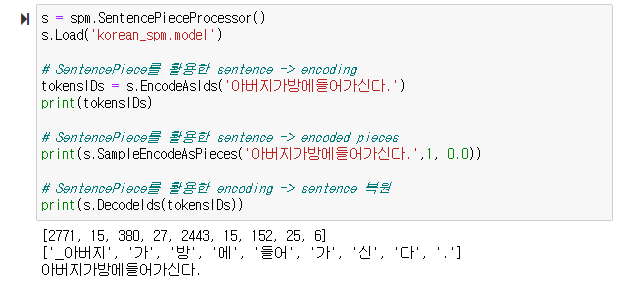

In [223]:
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/review/ratings.txt --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/review/ratings.txt
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  e

In [224]:
!ls -l korean_spm*

-rw-r--r-- 1 root root 368314 Oct 11 02:46 korean_spm.model
-rw-r--r-- 1 root root 137806 Oct 11 02:46 korean_spm.vocab


In [225]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[2771, 15, 380, 27, 2443, 15, 152, 25, 6]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## Step3. Tokenizer 함수 작성

In [28]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

# 2. text classifier, test accuracy 알아서 확인해보기 



- 데이터셋 로드

In [219]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/review/ratings.txt')
test_data = pd.read_table('~/review/ratings_test.txt')

train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


* document key error
    - train data 인덱싱 다시함
    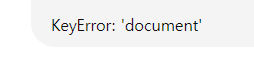
    위 train data 구조 아래 test 데이터 구조
    이유는 모르겠으나 index 없이 데이터가 하나씩 위로 밀린 모습
    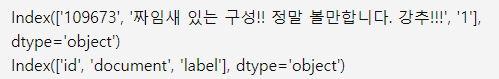
    - 으로 해결하려 했으나 머리아픔
    - ratings_train이 앞에서부터 잘라쓰고, ratings_test가 뒤에서부터 잘라쓰니까
    - 그냥 ratings 앞에서부터 파이썬 코드로 잘라서 train data로 사용

## Mecab 기반 토큰화

In [213]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 0


def load_data(train_data, test_data, num_words=num_words):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
    

Epoch 1/50
760/760 [==============================] - 7s 8ms/step - loss: 0.3663 - accuracy: 0.8376 - val_loss: 0.2710 - val_accuracy: 0.8913
Epoch 2/50
760/760 [==============================] - 6s 8ms/step - loss: 0.2710 - accuracy: 0.8883 - val_loss: 0.2111 - val_accuracy: 0.9212
Epoch 3/50
760/760 [==============================] - 6s 8ms/step - loss: 0.2110 - accuracy: 0.9175 - val_loss: 0.1527 - val_accuracy: 0.9473
Epoch 4/50
760/760 [==============================] - 6s 8ms/step - loss: 0.1510 - accuracy: 0.9455 - val_loss: 0.0982 - val_accuracy: 0.9690
Epoch 5/50
760/760 [==============================] - 6s 8ms/step - loss: 0.1010 - accuracy: 0.9655 - val_loss: 0.0656 - val_accuracy: 0.9794
Epoch 6/50
760/760 [==============================] - 6s 8ms/step - loss: 0.0676 - accuracy: 0.9778 - val_loss: 0.0481 - val_accuracy: 0.9851
Epoch 7/50
760/760 [==============================] - 6s 8ms/step - loss: 0.0469 - accuracy: 0.9848 - val_loss: 0.0322 - val_accuracy: 0.9891
Epoch 

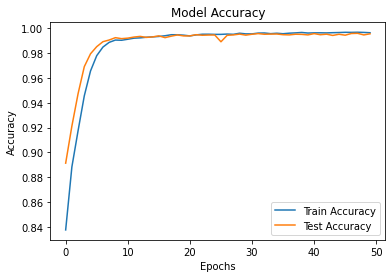

In [247]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.preprocessing.sequence import pad_sequences

# 하이퍼파라미터
embedding_dim = 128
max_length = 100  # 각 문장 길이
batch_size = 256
epochs = 50

# 데이터 패딩
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post')

# 모델 정의
model = Sequential()
model.add(Embedding(input_dim=len(word_to_index), output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))  # 클래스 수에 맞게 조정
model.add(Dense(1, activation='sigmoid'))  # 이진 분류일 경우

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test_padded, y_test), verbose=1)

# 훈련 정확도 그래프 그리기
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## SentencePiece 기반 토큰화

In [226]:
import sentencepiece as spm

# SentencePiece 설정
vocab_size = 8000
temp_file = 'train_data2.txt'  # 데이터 저장할 임시 파일 경로

# 파일 저장
with open(temp_file, 'w', encoding='utf-8') as f:
    for sentence in train_data['document']:
        f.write(str(sentence) + '\n')

# SentencePiece 모델 학습
spm.SentencePieceTrainer.Train(f'--input={temp_file} --model_prefix=korean_spm --vocab_size={vocab_size}')

# SentencePiece 모델 로드
sp = spm.SentencePieceProcessor()
sp.Load('korean_spm.model')

# SentencePiece 기반 데이터 토큰화
def load_data_sentencepiece(train_data, test_data):
    # document 칼럼이 문자열로 되어있는지 확인하고 변환
    train_data['document'] = train_data['document'].astype(str)
    test_data['document'] = test_data['document'].astype(str)

    X_train = [sp.EncodeAsIds(sentence) for sentence in train_data['document']]
    X_test = [sp.EncodeAsIds(sentence) for sentence in test_data['document']]
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label']))

X_train_spm, y_train_spm, X_test_spm, y_test_spm = load_data_sentencepiece(train_data, test_data)


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=train_data.txt --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: train_data.txt
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_pie

### 모델 테스트 중 data size 이슈
- 바보이슈! spm 처리한거랑 mecab 처리한거랑 같이 해서 데이터 테스트 하려고 하고 있었음....; 
- X_train_spm 이랑 y_test(mecab 처리) 를 비교하려니까 안맞음..
- 왜냐면 mecab 처리 후 토큰이 짧은 것들은 갖다버려서 길이가 다름!

In [240]:
X_train_spm, y_train_spm, X_test_spm, y_test_spm = load_data_sentencepiece(train_data, test_data)

# 크기 확인
print(f'X_train_spm size: {len(X_train_spm)}, y_train_spm size: {len(y_train_spm)}')
print(f'X_test_spm size: {len(X_test_spm)}, y_test_spm size: {len(y_test_spm)}')


X_train_spm size: 200000, y_train_spm size: 200000
X_test_spm size: 50000, y_test_spm size: 50000


In [248]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.preprocessing.sequence import pad_sequences

# 하이퍼파라미터
embedding_dim = 128
max_length = 100  # 각 문장 길이
batch_size = 256
epochs = 50

# 데이터 패딩
X_train_padded = pad_sequences(X_train_spm, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_spm, maxlen=max_length, padding='post')



Epoch 1/50
782/782 [==============================] - 7s 8ms/step - loss: 0.3694 - accuracy: 0.8344 - val_loss: 0.2659 - val_accuracy: 0.8932
Epoch 2/50
782/782 [==============================] - 6s 8ms/step - loss: 0.2713 - accuracy: 0.8868 - val_loss: 0.1927 - val_accuracy: 0.9331
Epoch 3/50
782/782 [==============================] - 6s 8ms/step - loss: 0.1991 - accuracy: 0.9227 - val_loss: 0.1174 - val_accuracy: 0.9670
Epoch 4/50
782/782 [==============================] - 6s 8ms/step - loss: 0.1160 - accuracy: 0.9601 - val_loss: 0.0621 - val_accuracy: 0.9832
Epoch 5/50
782/782 [==============================] - 6s 8ms/step - loss: 0.0591 - accuracy: 0.9812 - val_loss: 0.0346 - val_accuracy: 0.9898
Epoch 6/50
782/782 [==============================] - 6s 8ms/step - loss: 0.0324 - accuracy: 0.9900 - val_loss: 0.0194 - val_accuracy: 0.9940
Epoch 7/50
782/782 [==============================] - 6s 8ms/step - loss: 0.0223 - accuracy: 0.9930 - val_loss: 0.0163 - val_accuracy: 0.9947
Epoch 

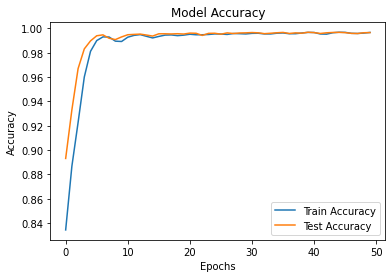

In [249]:
# 모델 정의
model = Sequential()
model.add(Embedding(input_dim=len(word_to_index), output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))  # 클래스 수에 맞게 조정
model.add(Dense(1, activation='sigmoid'))  # 이진 분류일 경우

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train_padded, y_train_spm, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test_padded, y_test_spm), verbose=1)

# 훈련 정확도 그래프 그리기
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# 회고
- review 데이터를 깃허브에서 가져오는 과정에서 train data 인덱싱 오류로 많은 시간을 썼음.
- 오류를 1. labe을 내가 직접 추가하여 해결 을 하고 싶었으나 2. label이 잘 정의된 데이터를 가져오는 식 으로 해결함
- 데이터 갖다 쓰는데 변수 명 착각으로 바보 이슈가 있었다.... -> 변수 명을 명확히 잘 쓰자